This notebook provides the code and output used for the analysis of a combined RefSeq, Ensmebl, Cufflinks and Trinity chicken superTranscriptome. The files it uses are also provided, so that the results can be reproduced and explored.

In [34]:
## Load up the block annotation information
## The overlaps.counts was created from featureCounts.
## We used blat and bedtools to annotate regions of the superTranscripts
## E-Ensmebl, T-Trinity, C-Cufflinks, R-RefSeq.
counts=read.delim("overlaps.counts",header=F,stringsAsFactors=F,skip=2)[,c(1:2,6,7:10)]
counts$type=sapply(strsplit(counts$V1,"-",fixed=T),function(x){ x[4] })
counts$counts<-rowSums(counts[,4:7])

blocks=counts[,c("V2","V1","V6","type","counts")]
colnames(blocks)=c("gene","id","length","type","counts")
head(blocks)

,gene,id,length,type,counts
1,1,1-0-726-E,727,E,2
2,1,"1-726-802-E,T",77,"E,T",0
3,1,1-802-803-E,2,E,0
4,1,"1-803-1098-E,T",296,"E,T",1
5,1,1-1098-1556-E,459,E,2.5
6,1,"1-1556-1955-E,T",400,"E,T",5.5


In [35]:
# make granges for each of the genes
library("GenomicRanges")
gene_lengths=read.delim("SuperDuper.fasta.fai",stringsAsFactors=F,header=F)[,1:2]
n=dim(gene_lengths)[1]
gene_gr=GRanges(gene_lengths[,1],IRanges(rep(1,n),gene_lengths[,2]),rep("*",n))

In [36]:
## Print some stats about the superTranscriptome.
## number of bases contributed by each transcript source
total=sum(width(ranges(gene_gr)))

message("Total: ",total," bp")
message("Ensembl: ",sum(blocks$length[grep("E",blocks$type)])/total*100," %")
message("RefSeq: ",sum(blocks$length[grep("R",blocks$type)])/total*100," %")
message("Cufflinks: ",sum(blocks$length[grep("C",blocks$type)])/total*100," %")
message("Trinity: ",sum(blocks$length[grep("T",blocks$type)])/total*100," %")


Total: 83292182 bp
Ensembl: 47.2149390923628 %
RefSeq: 16.8864503993904 %
Cufflinks: 77.4873096733136 %
Trinity: 87.6023046196581 %


In [37]:
# make granges for the parts of super transcripts that align to the genome
gpsl=read.delim("SuperDuper.genome.psl",skip=5, stringsAsFactors=F,header=F)
widths=as.numeric(unlist(strsplit(gpsl$V19,",")))
starts=as.numeric(unlist(strsplit(gpsl$V20,",")))
strand=rep(gpsl$V9,gpsl$V18)
gene=rep(gpsl$V10,gpsl$V18)
gene_end=as.numeric(rep(gpsl$V11,gpsl$V18))
starts[strand=="-"]=gene_end[strand=="-"]-starts[strand=="-"]-widths[strand=="-"]

genome_gr=GRanges(gene,IRanges(start=starts+1,width=widths),strand=rep("*",sum(gpsl$V18)))
genome_gr=reduce(genome_gr)

In [38]:
# How much of the superTranscripts is not in the genome
size<-function(x){ sum(width(ranges(x))) }
size(not_in_genome)/size(gene_gr)

[1] 0.03138513

In [39]:
# make granges for each super transcript block that is only annoated by trinity
tblocks=blocks[blocks$type=="T",]
tstart=as.numeric(sapply(strsplit(tblocks$id,"-",fixed=T),function(x){ x[2] }))+1
tend=as.numeric(sapply(strsplit(tblocks$id,"-",fixed=T),function(x){ x[3] }))+1
n=length(tstart)
t_gr=GRanges(tblocks$gene,IRanges(tstart,tend),rep("*",n))

In [40]:
# make granages for the bits that match human coding sequence

hblast=read.delim("SuperDuper.human_blast.txt",stringsAsFactors=F,header=F)

colnames(hblast)<-c("qseqid","sseqid","pident","length","mismatch",
                    "gapopen","qstart","qend","sstart","send",
                    "evalue","bitscore")

start=hblast$qstart
end=hblast$qend
neg = hblast$qend < hblast$qstart
start[neg]<-end[neg]
end[neg]<-hblast$qstart[neg]

human_gr=GRanges(hblast$qseqid,IRanges(start,end),strand=rep("*",length(start)))
human_gr=reduce(unlist(human_gr))

In [41]:
# For the novel stuff:
# we want the set of ranges that are not in the genome, 
# but annoated by trinity and match a human coding gene

# This is the same as asking for the intersection of blocks that:
# match human coding sequence (human_gr)
# are not in the chicken genome (genome_gr)
# are only annotated by Trinity (t_gr)

options(warn=-1)
not_in_genome=setdiff(gene_gr,genome_gr)
not_in_genome_coding=intersect(not_in_genome,human_gr)
not_in_genome_coding_trin=intersect(not_in_genome_coding,t_gr)
options(warn=0)


In [42]:
# remove novel bits which are less than 30 bp?
novel=not_in_genome_coding_trin[width(ranges(not_in_genome_coding_trin))>=30]
novel_bits=unique(as.character(as.data.frame(novel)$seqnames))

# how many genes are their with novel bits?
length(novel_bits)

[1] 1430

In [45]:
## Which of these novel bits belong to a gene that's not in the genome at all
## i.e. no genomic alignment and all blocks annotated to Trinity only
options(warn=-1)
in_genome_coding=intersect(genome_gr,human_gr)
options(warn=0)

novel_genes=novel_bits[!novel_bits %in% seqnames(in_genome_coding)]
temp=sapply(split(blocks$type,blocks$gene),function(x){all(x=='T') })
novel_genes=sapply(split(blocks$type,blocks$gene),function(x){all(x=='T') })[novel_genes]
novel_genes=names(novel_genes)[novel_genes]
length(novel_genes)
## print the name of the human ensmebl gene these chicken genes match
novel_genes

[1] 135

[1] "ENSG00000149541" "ENSG00000168481" "ENSG00000173137" "ENSG00000105401"
  [5] "ENSG00000136444" "ENSG00000109047" "ENSG00000181222" "ENSG00000108518"
  [9] "ENSG00000173581" "ENSG00000173171" "ENSG00000104852" "ENSG00000161638"
 [13] "ENSG00000004848" "ENSG00000073009" "ENSG00000134202" "ENSG00000183283"
 [17] "ENSG00000084090" "ENSG00000165462" "ENSG00000063177" "ENSG00000105655"
 [21] "ENSG00000129910" "ENSG00000139531" "ENSG00000136271" "ENSG00000116584"
 [25] "ENSG00000160767" "ENSG00000168495" "ENSG00000104957" "ENSG00000197901"
 [29] "ENSG00000079435" "ENSG00000144043" "ENSG00000130734" "ENSG00000105618"
 [33] "ENSG00000179091" "ENSG00000076984" "ENSG00000184271" "ENSG00000108106"
 [37] "ENSG00000165355" "ENSG00000167470" "ENSG00000015285" "ENSG00000139579"
 [41] "ENSG00000125651" "ENSG00000105520" "ENSG00000105372" "ENSG00000063244"
 [45] "ENSG00000143258" "ENSG00000104884" "ENSG00000099341" "ENSG00000142186"
 [49] "ENSG00000135454" "ENSG00000125084" "ENSG00000178498" "ENSG00000185000"
 [53] "ENSG00000039650" "ENSG00000130175" "ENSG00000188483" "ENSG00000142541"
 [57] "ENSG00000197858" "ENSG00000103495" "ENSG00000087087" "ENSG00000215041"
 [61] "ENSG00000154832" "ENSG00000122877" "ENSG00000142507" "ENSG00000108528"
 [65] "ENSG00000104856" "ENSG00000183207" "ENSG00000146834" "ENSG00000179388"
 [69] "ENSG00000167645" "ENSG00000143554" "ENSG00000132004" "ENSG00000187954"
 [73] "ENSG00000105048" "ENSG00000131795" "ENSG00000161914" "ENSG00000180879"
 [77] "ENSG00000133895" "ENSG00000163463" "ENSG00000204463" "ENSG00000180828"
 [81] "ENSG00000179041" "ENSG00000162734" "ENSG00000170889" "ENSG00000131446"
 [85] "ENSG00000115274" "ENSG00000104859" "ENSG00000138030" "ENSG00000165819"
 [89] "ENSG00000221983" "ENSG00000144485" "ENSG00000105698" "ENSG00000131188"
 [93] "ENSG00000160948" "ENSG00000111481" "ENSG00000166886" "ENSG00000142546"
 [97] "ENSG00000161956" "ENSG00000100253" "ENSG00000178719" "ENSG00000104881"
[101] "ENSG00000015520" "ENSG00000168002" "ENSG00000132017" "ENSG00000204681"
[105] "ENSG00000101997" "ENSG00000137411" "ENSG00000091640" "ENSG00000160211"
[109] "ENSG00000123136" "ENSG00000175467" "ENSG00000178952" "ENSG00000105771"
[113] "ENSG00000204209" "ENSG00000142552" "ENSG00000188686" "ENSG00000117289"
[117] "ENSG00000095066" "ENSG00000105732" "ENSG00000088038" "ENSG00000173599"
[121] "ENSG00000011485" "ENSG00000135517" "ENSG00000248713" "ENSG00000105329"
[125] "ENSG00000125656" "ENSG00000204310" "ENSG00000185482" "ENSG00000213339"
[129] "ENSG00000174282" "ENSG00000068438" "ENSG00000112511" "ENSG00000197093"
[133] "ENSG00000125743" "ENSG00000142453" "ENSG00000087152"

In [46]:
### and now the genes with a partial match to the genome.
novel_bits=novel_bits[!novel_bits %in% novel_genes]

# how many partial matches
length(novel_bits)


[1] 1295

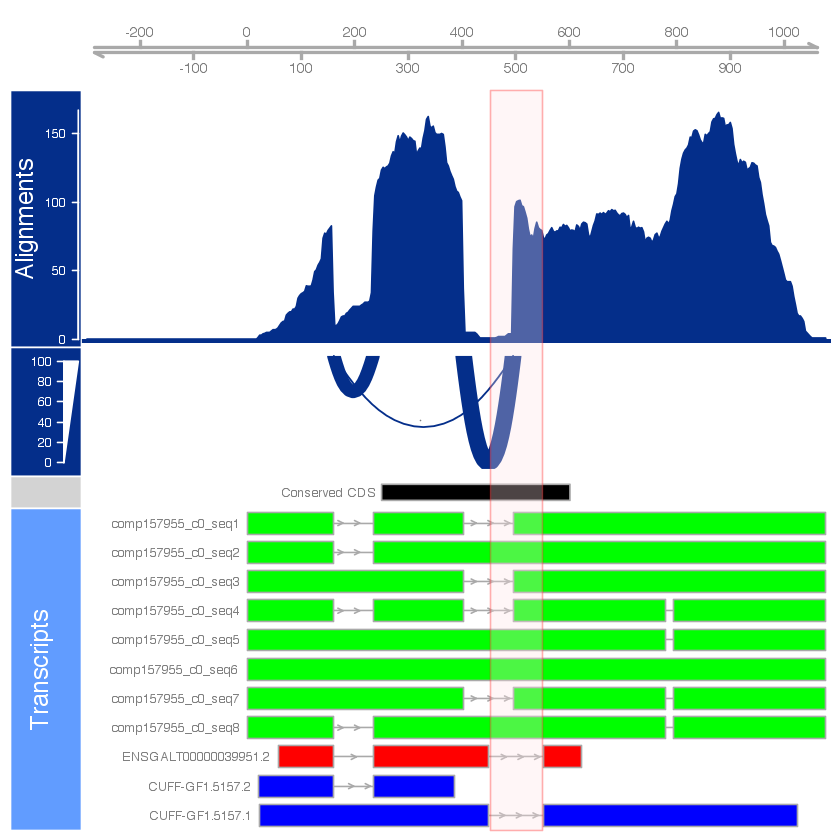

In [47]:
## now draw an example - Loci 10014
library(Gviz)
options(ucscChromosomeNames=FALSE)

gene="10014"

afrom <- -300 #1
ato <- gene_lengths$V2[gene_lengths$V1==gene]

#genomic gap
not_in_genome_pos=not_in_genome[seqnames(not_in_genome)==gene]

#alignment track
alTrack1 <- AlignmentsTrack("GF1_10014.bam",type = c("coverage"),name="Alignments",
                            background.title ="#042E8A",col="#042E8A",fill="#042E8A")
alTrack2 <- AlignmentsTrack("GF1_10014.bam",type = c("sashimi"),sashimiHeight=100,name=" ",
                               background.title ="#042E8A",col="#042E8A",fill="#042E8A")

#human match
human_pos=human_gr[seqnames(human_gr)==gene]
humTrack <- AnnotationTrack(human_pos,fill="black",name="CDS",
                            group="Conserved CDS",
                            groupAnnotation = "group")

#add in the transcripts
library(rtracklayer)
transGranges<-as(import.gff("10014.gff"), "GRanges")
elementMetadata(transGranges)$transcript=gsub("_mid1","",mcols(transGranges)$Parent)

col<-rep("red",length(transGranges))
col[grep("CUFF",mcols(transGranges)$Parent)]<-"blue"
col[grep("com",mcols(transGranges)$Parent)]<-"green"
transTrack=GeneRegionTrack(transGranges,fill=col,name="Transcripts",background.title ="#619CFF")


#AnnotationTrack(starts=c(100,400),width=100,chromosome=gene)

#genomic gap highlight
#not_in_genome_pos=not_in_genome[seqnames(not_in_genome)==gene]
ht <- HighlightTrack(trackList = list(alTrack1,alTrack2,humTrack,transTrack),#alTrack2,transTrack),
                     not_in_genome_pos,alpha=0.3,inBackground=F)

#pdf(file="chicken_pic.pdf")
plotTracks(c(GenomeAxisTrack(),ht), from = afrom, 
           to = ato,chromosome=gene,
           transcriptAnnotation = "transcript",
           sizes=c(0.25,0.8,0.4,0.1,1))
#dev.off()

In [48]:
# Now lets get a more global picture of these novel bits.
# where are they from and are they consistent with known
# gaps in the chicken genome

# get the genomic positions of these
novel_psl=gpsl[gpsl$V10 %in% novel_bits, ]

snovel_psl=split(novel_psl,novel_psl$V10)
#if there is more than one location choose the longest alignment
snovel_psl=lapply(snovel_psl,function(x){ x[which.max(x$V1),] })
novel_psl=do.call(rbind,snovel_psl)

#Make a GRanges object for the genome locations
novel_genome_gr=GRanges(novel_psl$V14,IRanges(novel_psl$V16,novel_psl$V17),rep("*",length(novel_psl$V14)))

length(novel_genome_gr)
## We miss 9 (have a cufflink block? but not in genome?)


[1] 1286

genes with novel coding bit not in genome: 1286
Warning message:
In eval(expr, envir, enclos): NAs introduced by coerciongenes with novel coding bit not in genome: 604
Warning message:
In eval(expr, envir, enclos): NAs introduced by coercion

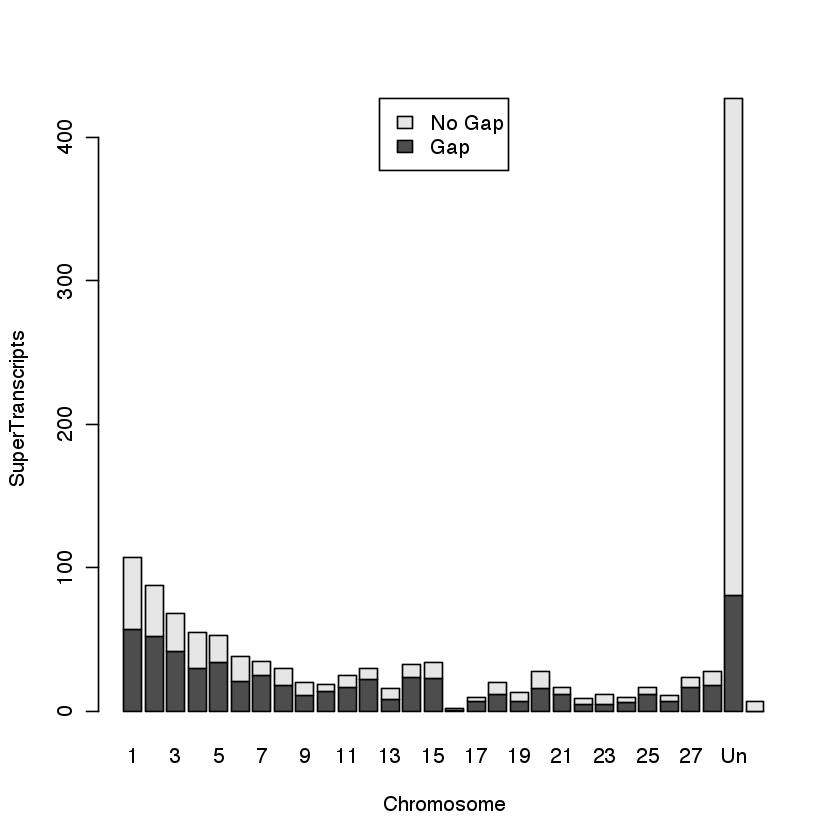

In [49]:
## now load in the position of genomic gaps

gaps_tab=read.delim("gaps.txt",stringsAsFactors=F,head=F)
gaps=GRanges(gaps_tab$V1,IRanges(gaps_tab$V2,gaps_tab$V3),rep("*",length(gaps_tab$V1)))
gaps=gaps[width(ranges(gaps))>=30]

get_chrom_table<-function(gr){
   places=as.character(seqnames(gr))
   message("genes with novel coding bit not in genome: ",length(places))
   places[grep("chrUn",places)]<-"Un"
   places[grep("random",places)]<-"Un"
   places[grep("LGE",places)]<-"Un"
   places<-gsub("chr","",places)
   hPlaces<-table(places)
   hPlaces[order(as.numeric(names(hPlaces)))]
}
    

#How many intersect a known gap in the genome
options(warn=-1)
overlaps=findOverlaps(gaps,novel_genome_gr)
options(warn=0)

all=get_chrom_table(novel_genome_gr)
with_gap<-rep(0,length(all))
names(with_gap)<-names(all)
has_gap=unique(subjectHits(overlaps))
gap_telli=get_chrom_table(novel_genome_gr[has_gap])
with_gap[names(gap_telli)]<-gap_telli
telli<-t(as.matrix(data.frame(with_gap,all-with_gap)))

#pdf( "chicken_genomic_view.pdf", width = 15, height = 10 )
barplot(telli,
        xlab="Chromosome",ylab="SuperTranscripts",
        legend = c("Gap","No Gap"),
        args.legend = list(x = "top")
        )
#dev.off()

In [50]:
## as a sanity check, how does this compare to gene with no novel sequence?

non_novel_psl=gpsl[!gpsl$V10 %in% novel_bits, ]

snon_novel_psl=split(non_novel_psl,non_novel_psl$V10)
#if there is more than one location choose the longest alignment
snon_novel_psl=lapply(snon_novel_psl,function(x){ x[which.max(x$V1),] })
non_novel_psl=do.call(rbind,snon_novel_psl)

#Make a GRanges object for the genome locations
non_novel_genome_gr=GRanges(non_novel_psl$V14,IRanges(non_novel_psl$V16,non_novel_psl$V17),rep("*",length(non_novel_psl$V14)))

options(warn=-1)
non_novel_overlaps=findOverlaps(gaps,non_novel_genome_gr)
options(warn=0)

non_novel_has_gap=unique(subjectHits(non_novel_overlaps))
message("No. where gene has a gap: ",length(non_novel_has_gap))
message("No. of genes: ",length(snon_novel_psl))

No. where gene has a gap: 3292
No. of genes: 22902
